In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Markdown, display

## Overview
Our approach is composed of two phases: **Offline Pre-training** and **Online Learning**. 

In the offline pre-training phase, the agent is initialized by observing and learning from historical data of the existing controller. Such data is typically logged in Building Automation System (BAS) and readily available. 

Then, in the online learning phase, the agent is put in charge of controlling the environment. Since, the Gnu-RL agent is pretrained with the historical state-action pair of the existing controller, it behaves similarly to the existing controller at the onset of online training phase. Then, it updates its policy end-to-end with a policy gradient algorithm. Thus, the agent improves its policy over time with new observations.   

<img src="imgs/framework.png">


## Simulation Testbed
We compare two control strategies, a baseline EnergyPlus control and our proposed Gnu-RL control. 

In the **Offline Pretraining** phase, we use a baseline EnergyPlus controller to simulate state-action pairs as expert demonstration and initialize the Gnu-RL agent by imitating the behaviours of the baseline EnergyPlus controller. 

In the **Online Learning** phase, we put the initialized Gnu-RL agent in charge of controlling the environment and compare its performance to that of the baseline EnergyPlus controller. 

We use two different weather sequences, TMY2 and TMY3, for **Offline Pretraining** and **Online Learning** respectively. The simulation runs from Jan. 1 to Mar. 31 based on Pittsburgh weather.  

The environments and their corresponding files are listed below.  

| **Environment Name** |**Model File (\*.idf)**|**Configuration File (\*.cfg)**|**Weather File (\*.epw)**| **Description**|
|:----------------|:---------------|:--------|:-----------|:--------------------------------|
|**5Zone-sim_TMY2-v0**|5Zone_Default.idf|variables_Default.cfg|pittsburgh_TMY2.epw|Baseline EnergyPlus control; Used in offline pretraining for expert demonstration|
|**5Zone-control_TMY3-v0**|5Zone_Control.idf|variables_Control.cfg|pittsburgh_TMY3.epw|Gnu-RL control; Used in online learning|
| **5Zone-sim_TMY3-v0**   | 5Zone_Default.idf|variables_Default.cfg|pittsburgh_TMY3.epw|Baseline EnergyPlus control; Used for performance benchmark|

 

### Model Description
The EnergyPlus model used for this demo was modified from *5ZoneAutoDXVAV.idf* in the example files included with EnergyPlus installation. It models a $463.6m^2$ single-floor rectangular building located in Pittsburgh. The space is partitioned into five thermal zones, i.e. one core zone and four permeter zones. The internal surfaces between the thermal zones are modeled with [IRTSurface](https://bigladdersoftware.com/epx/docs/8-0/engineering-reference/page-023.html). 

<img src="imgs/5Zone.png">

### HVAC
Since the simulation runs from Jan. 1 to Mar. 31 based on Pittsburgh weather, we do not consider cooling in this demonstration. 

The air conditioning to the building is supplied by an air handling unit (AHU) with a variable speed fan. The heating is provided by a main heating coil in the air handling unit. 

The terminal unit in each thermal zone controls the air flow rate based on single maximum control logic. Specifically, the airflow rate is kept at the minimum that satisfy outdoor air requirements during heating mode. The terminal unit takes in extra outdoor air for free cooling when the indoor air temperature gets too warm. The reheat coil is deactivated for the purpose of this demonstration. That is to say, the only source of heating is the main heating coil.

### Control
In this demonstration, we control the supply air temperature of the main AHU and let the terminal units determine the airflow based on default EnergyPlus control logic. In the baseline EnergyPlus control, we use the predefined [**SetpointManager:MultiZone:Heating:Average**](https://bigladdersoftware.com/epx/docs/8-0/input-output-reference/page-050.html#setpointmanagermultizoneheatingaverage) object. 

In the Gnu-RL control, the action is defined as the difference between Supply Air Temperature and Mixed Air Temperature, which is proportional to the energy consumption of the heating coil. The supply air temperature is then calculated and passed to EnergyPlus through the *Gym-Eplus* interface. 

### State-Action Space

| **State** |**Disturbance**| 
|:----------------|:---------------|
|Zone Temp.|Outdoor Temp.|
|**Setpoint**|Outdoor RH|
|Zone Temp. Setpoint|Wind Speed|
|**Action**|Wind Direction |
|$\Delta T = T_{SA}-T_{MA}$|Diff. Solar Rad.|
||Direct Solar Rad.|
||Occupancy Flag|

**Note:** $\Delta T$ is the temperature difference between the mixed air temperature, $T_{MA}$, and supply air temperature, $T_{SA}$. 

## Step 1: Offline Pretraining

In the **Offline Pretraining** phase, the Gnu-RL agent imitates the behaviours of the expert, i.e. the baseline EnergyPlus controller, by minimizing the imitation loss, $\mathcal{L}_{\text{Imit}}(\theta)$. Note that the Gnu-RL agent does not need to interact with the environment in the offline pretraining phase. 

- **Expert:** Baseline EnergyPlus controller (SetpointManager:MultiZone:Heating:Average)
- **Learner:** Gnu-RL agent
- **Weather Sequence:** Pittsburgh TMY2

$$\mathcal{L}_{\text{Imit}}(\theta) =  \sum_t \lambda(x_t-\hat{x}_t)^2+(u_t-\hat{u}_t)^2$$
where the hyperparameter $\lambda$ balances the relative importance of states and actions. 

<img src="imgs/offline.png" width="400" />

Since the agent does not have access to the environment during offline pretraining stage, it is not possible to directly select $\theta$ based on control performance. Instead, we split the historical data into training set and validation set, and used the imitation loss, $\mathcal{L}_{Imit}$, on the validation set as a proxy for performance. 

We repeat the procedures in Algorithm 1 for 20 epoches, and select the parameter, $\theta$, based on the loss on the validation set. 

Text(0.5, 0, 'Number of Epoches')

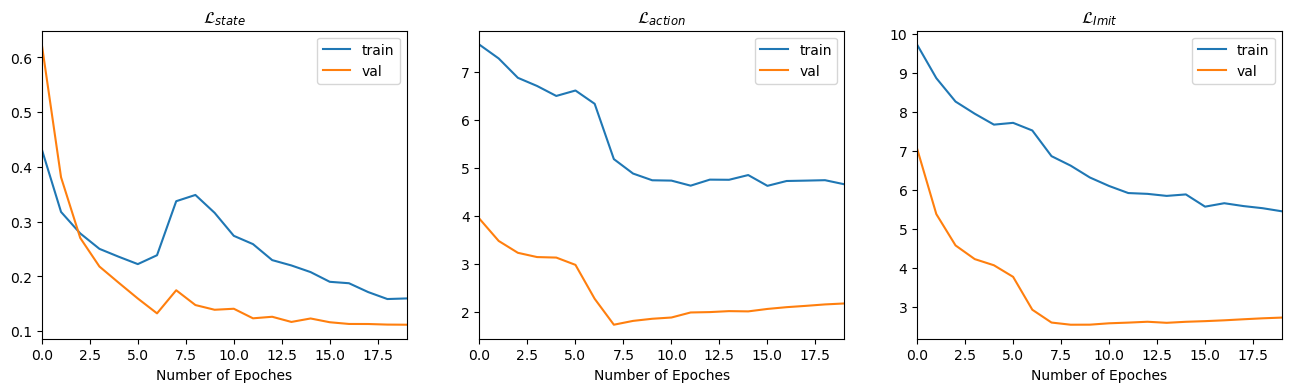

In [33]:
filePath = "results/"
lam = 5 
imit_loss = pd.read_pickle(filePath+"Imit_loss_rl.pkl")

fig = plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("$\mathcal{L}_{state}$")
plt.plot(imit_loss["train_state_loss"], label="train")
plt.plot(imit_loss["val_state_loss"], label = "val")
plt.legend()
plt.xlim((0, 19))
plt.xlabel("Number of Epoches")

plt.subplot(1,3,2)
plt.title("$\mathcal{L}_{action}$")
plt.plot(imit_loss["train_action_loss"], label="train")
plt.plot(imit_loss["val_action_loss"], label = "val")
plt.legend()
plt.xlim((0, 19))
plt.xlabel("Number of Epoches")

plt.subplot(1,3,3)
plt.title("$\mathcal{L}_{Imit}$")
plt.plot(lam* imit_loss["train_state_loss"]+ imit_loss["train_action_loss"], label="train")
plt.plot(lam* imit_loss["val_state_loss"]+imit_loss["val_action_loss"], label = "val")
plt.legend()
plt.xlim((0, 19))
plt.xlabel("Number of Epoches")

In [34]:
# Selected Epoch
epoch = 16
imit_record = pd.read_pickle(filePath+"Imit_rl_{}.pkl".format(epoch))

imit_record["Hour"] = pd.Series([time.hour for time in imit_record.index], index = imit_record.index)
imit_record["Occupancy Flag"] = (imit_record["Hour"]>=8) & (imit_record["Hour"]< 18)
imit_record["Indoor Temp. Setpoint"] = pd.Series([22.5 if occupied==1 else 12.8 for occupied in imit_record["Occupancy Flag"]], index = imit_record.index)

**Observation:**
The Gnu-RL agent learns to predict next state and imitate the expert in the offline pretraining phase.

/tmp/ipykernel_23256/1086939203.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_time = pd.datetime(year = 2017, month = 1, day = 1)


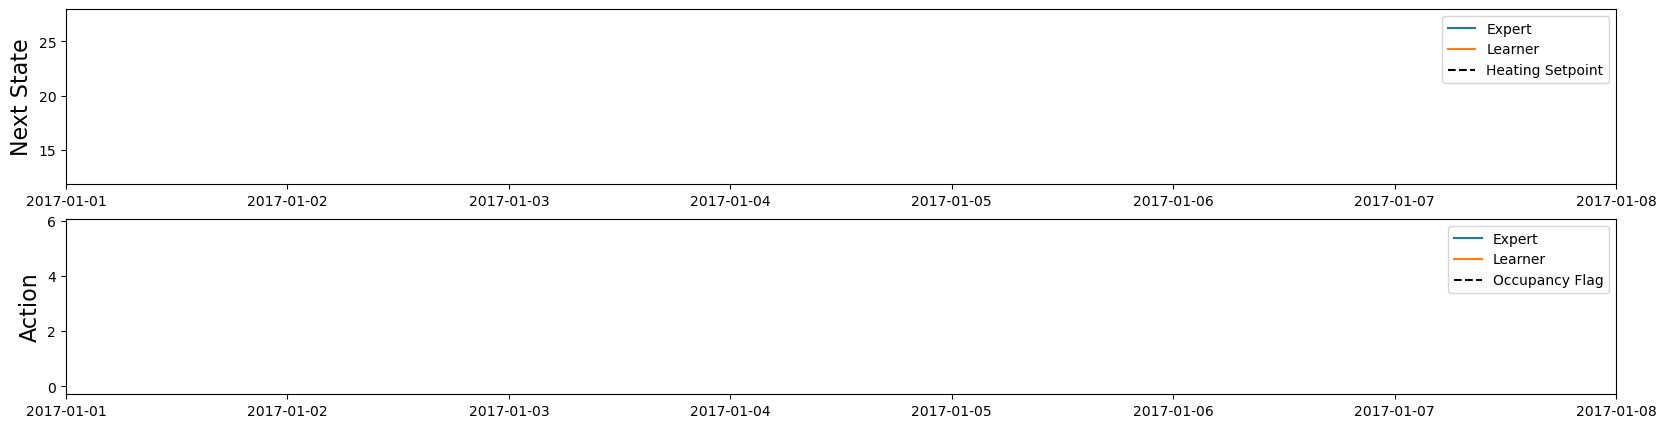

In [35]:
start_time = pd.datetime(year = 2017, month = 1, day = 1)
end_time = start_time + pd.Timedelta(days = 7)

fig = plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.plot(imit_record["Expert nState"], label = "Expert")
plt.plot(imit_record["Learner nState"], label = "Learner")
plt.plot(imit_record["Indoor Temp. Setpoint"], "k--", label = "Heating Setpoint")
plt.ylabel("Next State", fontsize = 16)
plt.xlim((start_time, end_time))
plt.legend()

plt.subplot(2,1,2)
plt.plot(imit_record["Expert action"], label = "Expert")
plt.plot(imit_record["Learner action"], label = "Learner")
plt.plot(imit_record["Occupancy Flag"]*5, 'k--', label = "Occupancy Flag")
plt.ylabel("Action", fontsize = 16)
plt.xlim((start_time, end_time))
plt.legend()

## Step 2: Online Learning
In the **online learning** phase, the agent updates the Differentiable MPC policy end-to-end with a policy gradient algorithm. Specifically, we used [proximal policy optimization (PPO)](https://arxiv.org/abs/1707.06347). 

The procedure is shown in Algorithm 2. 

<img src="imgs/online.png" width="400" />

In [20]:
exp_name = "rl"
baseline = pd.read_pickle(filePath+"Sim-TMY2.pkl")
rl = pd.read_pickle(filePath+"perf_"+exp_name+"_obs.pkl")
rl_action = pd.read_pickle(filePath+"perf_"+exp_name+"_actions.pkl")
rl = rl.merge(rl_action, left_index = True, right_index = True)

### Summary Statistics
**Conclusion:**
The Gnu-RL agent saves 10.8% of the energy consumed by the heating coil and 5.6% of the overall HVAC energy consumption compared to the baseline EnergyPlus controller, while maintaining similar level of thermal comfort.  

In [21]:
def CalcStatistics(obs):
    # PPD during Occipied period
    meanPPD = np.mean(obs[obs["Occupancy Flag"]==1]["PPD"])
    print("Average PPD = ", meanPPD)
    
    CoilPower = np.sum(obs["Coil Power"]) # Unit in W
    CoilEnergy = CoilPower*900/1000/3600 # Unit in kWh
    print("Energy Consumed by the Heating Coil = {:.2f}kWh".format(CoilEnergy))
    
    HVACPower = np.sum(obs["HVAC Power"]) # Unit in W
    HVACEnergy = HVACPower*900/1000/3600 # Unit in kWh
    print("Energy Consumed by the Heating Coil = {:.2f}kWh".format(HVACEnergy))

In [22]:
def printmd(string):
    display(Markdown(string))

In [23]:
printmd("**EnergyPlus Baseline**")
CalcStatistics(baseline)
printmd("**Gnu-RL**")
CalcStatistics(rl)

**EnergyPlus Baseline**

Average PPD =  18.968672500348198
Energy Consumed by the Heating Coil = 5730.27kWh
Energy Consumed by the Heating Coil = 9542.12kWh


**Gnu-RL**

Average PPD =  16.56002439741915
Energy Consumed by the Heating Coil = 4397.15kWh
Energy Consumed by the Heating Coil = 7529.53kWh


In [24]:
(4413.17-3935.91)/4413.17

0.10814448570981862

In [25]:
(7482.66-7063.86)/7482.66

0.05596940125570321

### At the beginning of training phase:
**Observations:** 
- The Gnu-RL agent behaves similarly to the existing controller prior to any interaction with the environment.
- The baseline EnergyPlus controller maintains the indoor air temperature at night, which consumes energy unnecessarily. The Gnu-RL agent allows the indoor air temperature to drop instead and thus conserves energy. 
- The Gnu-RL agent preheats the space in the early morning. But it underestimates the amount of preheating required. 

In [26]:
def plotPerf(rl, baseline, start_time, end_time):
    fig = plt.figure(figsize=(20,6))

    plt.subplot(2,1,1)
    plt.plot(baseline["Indoor Temp."], 'b-', label="EnergyPlus")
    plt.plot(rl["Indoor Temp."],'r-', label="Gnu-RL")
    plt.plot(rl["Indoor Temp. Setpoint"], 'k--')
    plt.legend()
    plt.ylabel("State\nIndoor Temp.", fontsize = 16)
    plt.xlim([start_time, end_time])

    plt.subplot(2,1,2)
    plt.plot(baseline["Sys Out Temp."],'b', label ="EnergyPlus")
    plt.plot(rl["Sys Out Temp."], 'r', label ="Gnu-RL")
    plt.plot(baseline["Occupancy Flag"]*30, 'k--', label= "Occupancy Flag")
    plt.xlim([start_time, end_time])
    plt.ylabel("Action\nSupply Air Temp.", fontsize = 16)
    plt.legend()

/tmp/ipykernel_23256/986103189.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_time = pd.datetime(year = 2017, month = 1, day = 1)


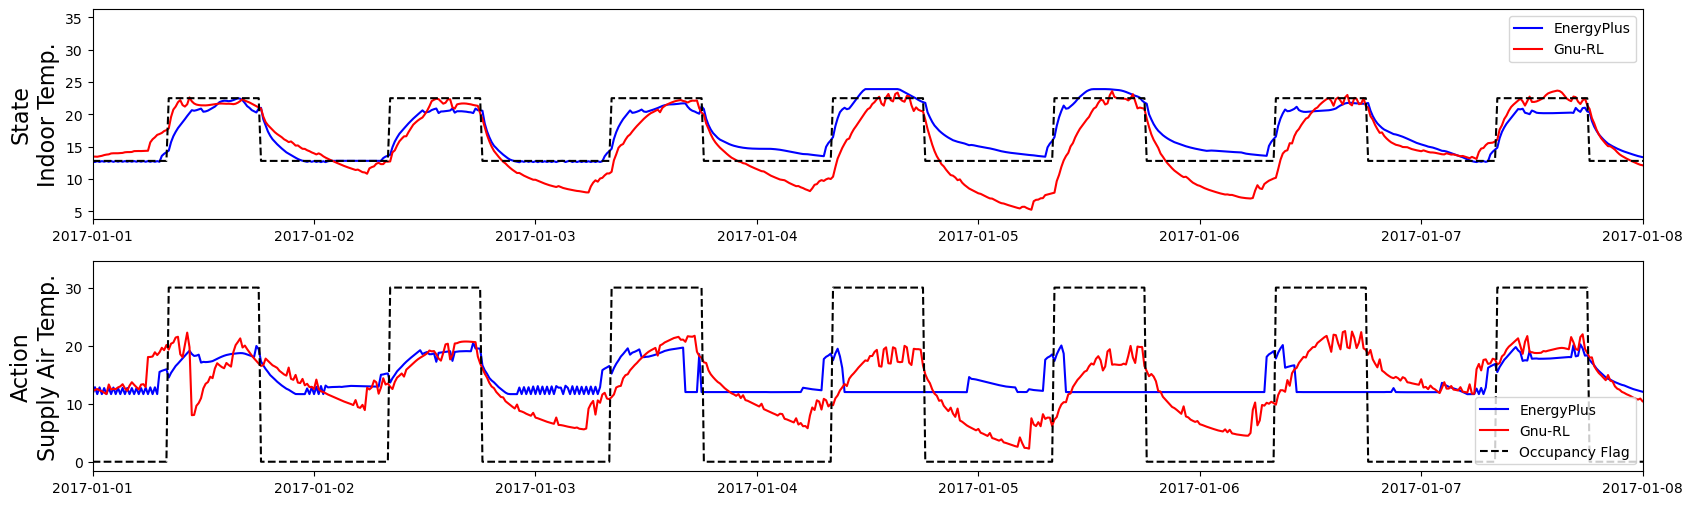

In [27]:
start_time = pd.datetime(year = 2017, month = 1, day = 1)
end_time = start_time + pd.Timedelta(days = 7)
plotPerf(rl, baseline, start_time, end_time)

### After training for a while:
**Observation:** The Gnu-RL agent estimates the amount of preheating required better.  

/tmp/ipykernel_23256/3357634741.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_time = pd.datetime(year = 2017, month = 2, day = 21)


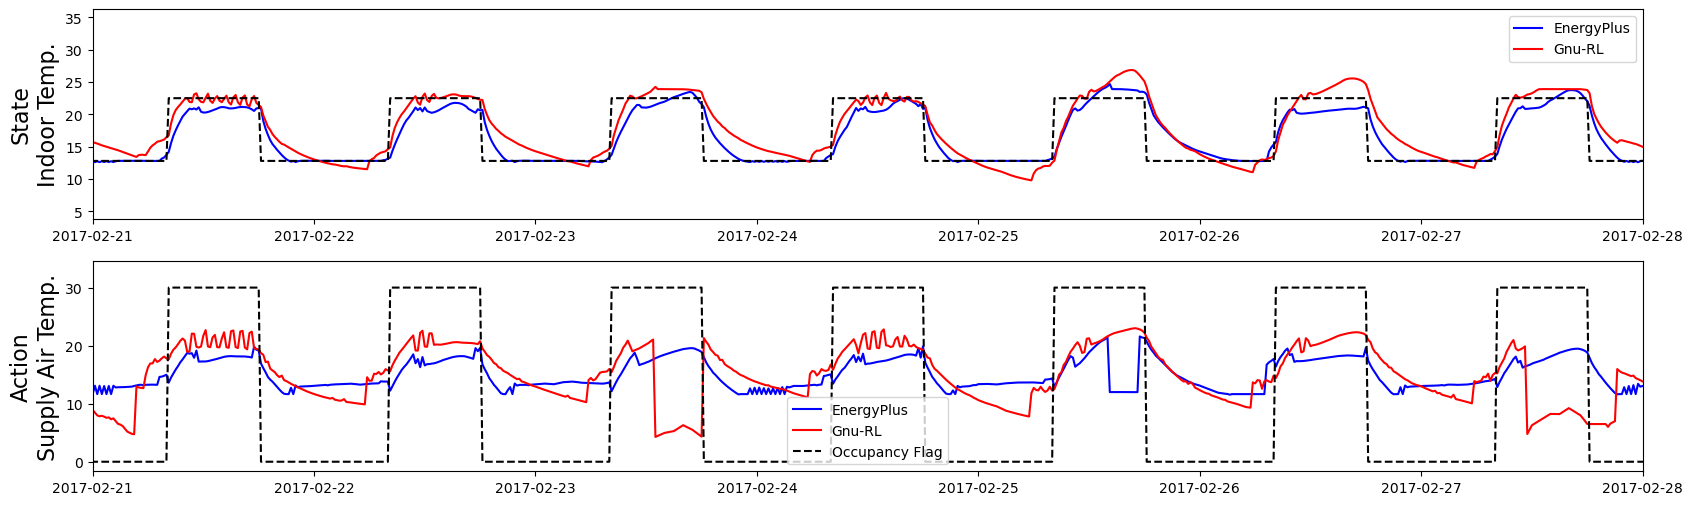

In [28]:
start_time = pd.datetime(year = 2017, month = 2, day = 21)
end_time = start_time + pd.Timedelta(days = 7)
plotPerf(rl, baseline, start_time, end_time)

### Compare the Reward between Gnu-RL and baseline EnergyPlus policy
Since the reward is also a function of weather, we show **Residue Reward** instead, which is defined as the difference between the rewards of Gnu-RL and that of the baseline controller. 

We show the averaged daily residue reward and its variance. 

In [29]:
def CalReward(df, eta):
    df["eta"] = pd.Series([eta[int(occupied)] for occupied in df["Occupancy Flag"]], index = df.index)
    df["Reward"] = - 0.5 * df["eta"] * (df["Indoor Temp."] - df["Indoor Temp. Setpoint"])**2 - df["Delta T"]
    return df

eta = [0.1, 4]

rl = CalReward(rl, eta)

baseline["Delta T"] = baseline["Sys Out Temp."] - baseline["MA Temp."]
baseline = CalReward(baseline, eta)

In [30]:
ResReward = pd.DataFrame(rl["Reward"]-baseline["Reward"])

ResReward["Day"] = pd.Series([time.day for time in ResReward.index], index = ResReward.index)
ResReward["Month"] = pd.Series([time.month for time in ResReward.index], index = ResReward.index)
mean = ResReward.groupby(["Month", "Day"]).mean()
std = ResReward.groupby(["Month", "Day"]).std()

index = pd.date_range(start='1/1/2017', end='3/31/2017')
RewardStats = pd.DataFrame(np.concatenate([mean.values[:90], std.values[:90]], axis =1), index = index, columns = ["Mean", "Std"])

/tmp/ipykernel_23256/2477724499.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_time = pd.datetime(year = 2017, month = 1, day = 1)
/tmp/ipykernel_23256/2477724499.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end_time =pd.datetime(year = 2017, month = 3, day = 31)


Text(0, 0.5, 'Residue Reward')

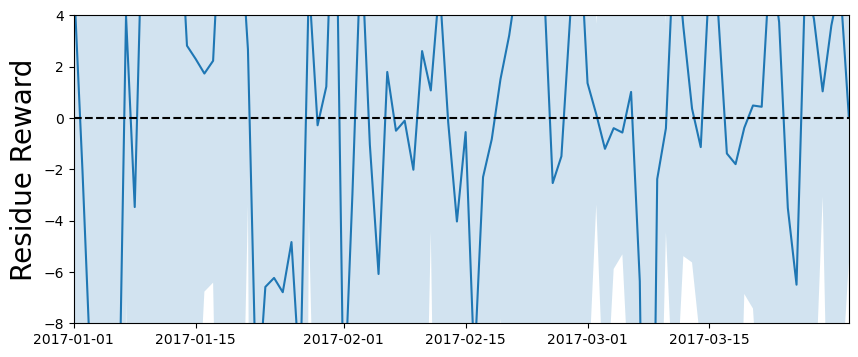

In [31]:
fig = plt.figure(figsize=(10, 4))

start_time = pd.datetime(year = 2017, month = 1, day = 1)
end_time =pd.datetime(year = 2017, month = 3, day = 31)

plt.plot(RewardStats["Mean"])
plt.fill_between(RewardStats.index, RewardStats["Mean"]-1.645*RewardStats["Std"], RewardStats["Mean"]+1.645*RewardStats["Std"], alpha = 0.2)

plt.plot((start_time, end_time), (0, 0), 'k--')

plt.xlim((start_time, end_time))
plt.ylim((-8, 4))

plt.ylabel("Residue Reward", fontsize = 20)